## 1. 数据加载与探索

In [157]:
from sklearn.datasets import fetch_20newsgroups

# 加载数据集并查看样本
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
train_dataset_raw = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_dataset_raw = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

sample = {
    "text_preview": train_dataset_raw.data[0][:200],
    "label": train_dataset_raw.target_names[train_dataset_raw.target[0]],
}
sample

{'text_preview': 'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard',
 'label': 'comp.graphics'}

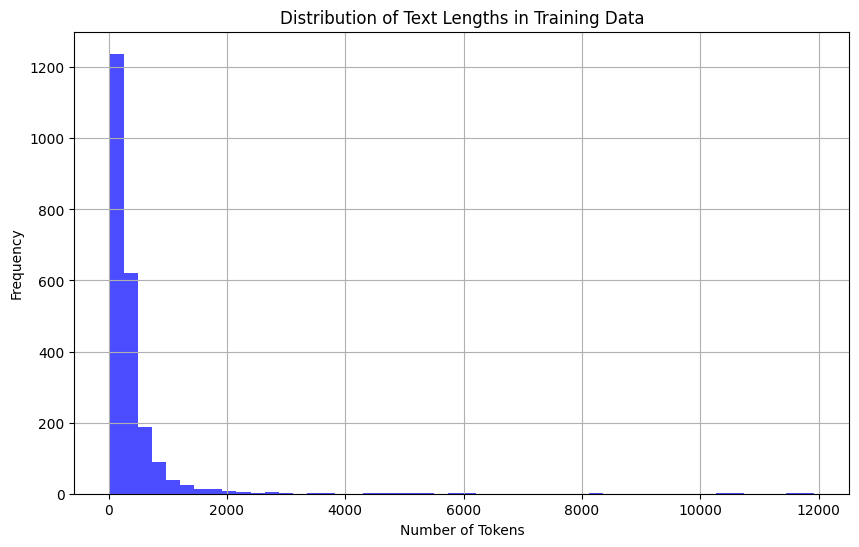

In [158]:
import re
import matplotlib.pyplot as plt

# 训练集文本长度分布

def basic_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9(),.!?\'`]", " ", text)
    text = re.sub(r"([,.!?\'`])", r" \1 ", text)
    return text.strip().split()

train_text_lengths = [len(basic_tokenize(text)) for text in train_dataset_raw.data]

plt.figure(figsize=(10, 6))
plt.hist(train_text_lengths, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

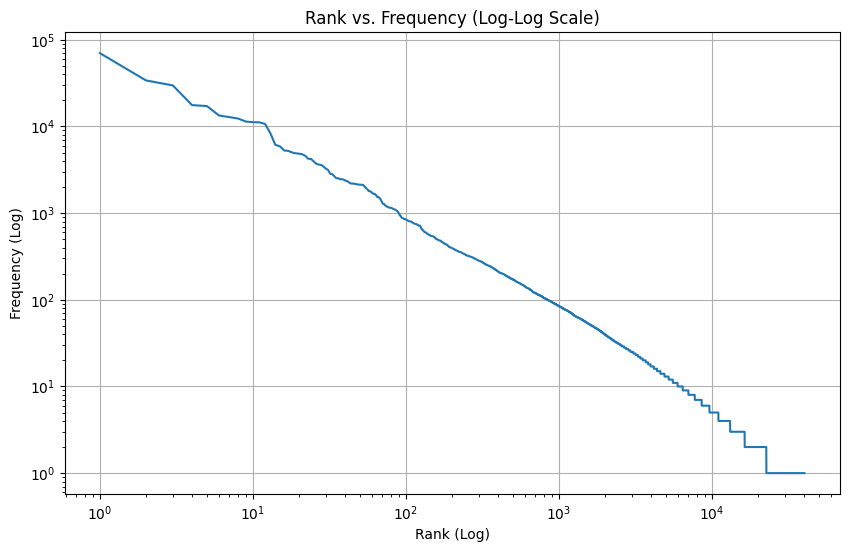

In [159]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(basic_tokenize(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()


## 2. 定义所需组件

In [160]:
class Tokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.token_to_id = {token: idx for token, idx in vocab.items()}

    @staticmethod
    def _tokenize_text(text):
        text = text.lower()
        text = re.sub(r"[^a-z0-9(),.!?\'`]", " ", text)
        text = re.sub(r"([,.!?\'`])", r" \1 ", text)
        tokens = text.strip().split()
        return tokens

    def convert_tokens_to_ids(self, tokens):
        return [self.token_to_id.get(token, self.vocab["<UNK>"]) for token in tokens]

    def tokenize(self, text):
        return self._tokenize_text(text)
    
    def __len__(self):
        return len(self.vocab)


In [161]:
def build_vocab_from_counts(word_counts, min_freq=5):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab_from_counts(word_counts, min_freq=5)
tokenizer = Tokenizer(vocab)
{"vocab_size": len(tokenizer)}

{'vocab_size': 10983}

In [162]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.processed_data = []

        for text, label in tqdm(zip(texts, labels), total=len(labels)):
            token_ids = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))
            
            if len(token_ids) <= self.max_len:
                self.processed_data.append({"token_ids": token_ids, "label": label})
            else:
                stride = max(1, int(self.max_len * 0.8))
                for i in range(0, len(token_ids) - self.max_len + 1, stride):
                    chunk = token_ids[i:i+self.max_len]
                    self.processed_data.append({"token_ids": chunk, "label": label})
    
    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]


In [163]:
def collate_fn(batch):
    max_batch_len = max(len(item["token_ids"]) for item in batch)
    
    batch_token_ids, batch_labels, batch_lengths = [], [], []

    for item in batch:
        token_ids = item["token_ids"]
        lengths = len(token_ids)
        padding_len = max_batch_len - lengths
        
        padded_ids = token_ids + [0] * padding_len
        batch_token_ids.append(padded_ids)
        batch_labels.append(item["label"])
        batch_lengths.append(lengths)
        
    return {
        "token_ids": torch.tensor(batch_token_ids, dtype=torch.long),
        "labels": torch.tensor(batch_labels, dtype=torch.long),
        "lengths": torch.tensor(batch_lengths, dtype=torch.long),
    }


In [164]:
from torch.utils.data import DataLoader

train_dataset = TextClassificationDataset(train_dataset_raw.data, train_dataset_raw.target, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

valid_dataset = TextClassificationDataset(test_dataset_raw.data, test_dataset_raw.target, tokenizer)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn)

{"train_samples": len(train_dataset), "valid_samples": len(valid_dataset), "batch_size": 32}

100%|██████████| 1502/1502 [00:00<00:00, 4878.14it/s]


{'train_samples': 7142, 'valid_samples': 5408, 'batch_size': 32}

## 3. 构建模型

In [165]:
class TextClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, n_layers=1, dropout=0.5, bidirectional=False):
        super(TextClassifierLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)
        
        num_directions = 2 if bidirectional else 1
        self.classifier = nn.Linear(hidden_dim * num_directions, num_classes)
        
    def forward(self, token_ids, lengths):
        embedded = self.embedding(token_ids)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
            
        logits = self.classifier(hidden)
        return logits


In [166]:
import os
import json
from tqdm import tqdm

class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, valid_loader, device, output_dir="."):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.best_accuracy = 0.0
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        self.train_losses = []
        self.val_accuracies = []

    def _run_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for batch in tqdm(self.train_loader, desc=f"Epoch {epoch+1} [训练中]"):
            self.optimizer.zero_grad()
            
            token_ids = batch["token_ids"].to(self.device)
            labels = batch["labels"].to(self.device)
            lengths = batch["lengths"] # lengths在pack_padded_sequence中需要在cpu上
            
            outputs = self.model(token_ids, lengths)
            loss = self.criterion(outputs, labels)
            total_loss += loss.item()
            
            loss.backward()
            self.optimizer.step()
        
        return total_loss / len(self.train_loader)

    def _evaluate(self, epoch):
        self.model.eval()
        correct_preds = 0
        total_samples = 0
        with torch.no_grad():
            for batch in tqdm(self.valid_loader, desc=f"Epoch {epoch+1} [评估中]"):
                token_ids = batch["token_ids"].to(self.device)
                labels = batch["labels"].to(self.device)
                lengths = batch["lengths"]
                
                outputs = self.model(token_ids, lengths)
                _, predicted = torch.max(outputs, 1)
                
                total_samples += labels.size(0)
                correct_preds += (predicted == labels).sum().item()
        
        return correct_preds / total_samples

    def _save_checkpoint(self, epoch, val_accuracy):
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            save_path = os.path.join(self.output_dir, "best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"新最佳模型已保存! Epoch: {epoch+1}, 验证集准确率: {val_accuracy:.4f}")

    def train(self, epochs, tokenizer, label_map):
        self.train_losses = []
        self.val_accuracies = []
        for epoch in range(epochs):
            avg_loss = self._run_epoch(epoch)
            val_accuracy = self._evaluate(epoch)
            
            self.train_losses.append(avg_loss)
            self.val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}/{epochs} | 训练损失: {avg_loss:.4f} | 验证集准确率: {val_accuracy:.4f}")
            
            self._save_checkpoint(epoch, val_accuracy)
        
        print("训练完成！")
        vocab_path = os.path.join(self.output_dir, 'vocab.json')
        with open(vocab_path, 'w', encoding='utf-8') as f:
           json.dump(tokenizer.vocab, f, ensure_ascii=False, indent=4)
           
        labels_path = os.path.join(self.output_dir, 'label_map.json')
        with open(labels_path, 'w', encoding='utf-8') as f:
           json.dump(label_map, f, ensure_ascii=False, indent=4)
        print(f"词典 ({vocab_path}) 和标签映射 ({labels_path}) 已保存。")
        return self.train_losses, self.val_accuracies


In [167]:
class Predictor:
    def __init__(self, model, tokenizer, label_map, device, max_len=128):
        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.id_to_label = {idx: label for label, idx in self.label_map.items()}
        self.device = device
        self.max_len = max_len

    def predict(self, text):
        token_ids = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))
        chunks = []
        if len(token_ids) <= self.max_len:
            chunks.append(token_ids)
        else:
            stride = max(1, int(self.max_len * 0.8))
            for i in range(0, len(token_ids) - self.max_len + 1, stride):
                chunks.append(token_ids[i:i + self.max_len])
        
        chunk_lengths = [len(c) for c in chunks]
        max_chunk_len = max(chunk_lengths) if chunk_lengths else 0
        
        padded_chunks = []
        for chunk in chunks:
            padding_len = max_chunk_len - len(chunk)
            padded_chunks.append(chunk + [0] * padding_len)
            
        if not padded_chunks:
            return "无法预测（文本过短）"

        chunk_tensors = torch.tensor(padded_chunks, dtype=torch.long).to(self.device)
        length_tensors = torch.tensor(chunk_lengths, dtype=torch.long) # lengths need to be on cpu
        
        with torch.no_grad():
            outputs = self.model(chunk_tensors, length_tensors)
            preds = torch.argmax(outputs, dim=1)

        final_pred_id = torch.bincount(preds).argmax().item()
        
        final_pred_label = self.id_to_label[final_pred_id]
        return final_pred_label


## 4. 训练模型


In [168]:
# 超参数
hparams = {
    "vocab_size": len(tokenizer),
    "embed_dim": 128,
    "hidden_dim": 256,
    "num_classes": len(train_dataset_raw.target_names),
    "n_layers": 2,
    "dropout": 0,
    "bidirectional": True,
    "epochs": 20,
    "learning_rate": 0.001,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "output_dir": "output_lstm"
}

# 实例化
model = TextClassifierLSTM(
    vocab_size=hparams["vocab_size"], 
    embed_dim=hparams["embed_dim"], 
    hidden_dim=hparams["hidden_dim"], 
    num_classes=hparams["num_classes"],
    n_layers=hparams["n_layers"],
    dropout=hparams["dropout"],
    bidirectional=hparams["bidirectional"]
).to(hparams["device"])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hparams["learning_rate"])
hparams

{'vocab_size': 10983,
 'embed_dim': 128,
 'hidden_dim': 256,
 'num_classes': 4,
 'n_layers': 2,
 'dropout': 0,
 'bidirectional': True,
 'epochs': 20,
 'learning_rate': 0.001,
 'device': 'cuda',
 'output_dir': 'output_lstm'}

In [169]:
trainer = Trainer(
    model, 
    optimizer, 
    criterion, 
    train_loader, 
    valid_loader, 
    hparams["device"], 
    output_dir=hparams["output_dir"]
)

label_map = {name: i for i, name in enumerate(train_dataset_raw.target_names)}

lstm_train_losses, lstm_val_accuracies = trainer.train(epochs=hparams["epochs"], tokenizer=tokenizer, label_map=label_map)

Epoch 1 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 91.87it/s]


Epoch 1/20 | 训练损失: 1.2318 | 验证集准确率: 0.3652
新最佳模型已保存! Epoch: 1, 验证集准确率: 0.3652


Epoch 2 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 86.36it/s]


Epoch 2/20 | 训练损失: 1.0290 | 验证集准确率: 0.6193
新最佳模型已保存! Epoch: 2, 验证集准确率: 0.6193


Epoch 3 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 93.78it/s]


Epoch 3/20 | 训练损失: 0.6753 | 验证集准确率: 0.6860
新最佳模型已保存! Epoch: 3, 验证集准确率: 0.6860


Epoch 4 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 87.68it/s]


Epoch 4/20 | 训练损失: 0.4679 | 验证集准确率: 0.7389
新最佳模型已保存! Epoch: 4, 验证集准确率: 0.7389


Epoch 5 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 88.57it/s]


Epoch 5/20 | 训练损失: 0.2767 | 验证集准确率: 0.7605
新最佳模型已保存! Epoch: 5, 验证集准确率: 0.7605


Epoch 6 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 85.46it/s]


Epoch 6/20 | 训练损失: 0.1707 | 验证集准确率: 0.7785
新最佳模型已保存! Epoch: 6, 验证集准确率: 0.7785


Epoch 7 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 81.72it/s]


Epoch 7/20 | 训练损失: 0.0736 | 验证集准确率: 0.7955
新最佳模型已保存! Epoch: 7, 验证集准确率: 0.7955


Epoch 8 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 88.15it/s]


Epoch 8/20 | 训练损失: 0.0487 | 验证集准确率: 0.7940


Epoch 9 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 90.43it/s]


Epoch 9/20 | 训练损失: 0.0120 | 验证集准确率: 0.7983
新最佳模型已保存! Epoch: 9, 验证集准确率: 0.7983


Epoch 10 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 84.59it/s]


Epoch 10/20 | 训练损失: 0.0075 | 验证集准确率: 0.8007
新最佳模型已保存! Epoch: 10, 验证集准确率: 0.8007


Epoch 11 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 84.08it/s]


Epoch 11/20 | 训练损失: 0.0237 | 验证集准确率: 0.8009
新最佳模型已保存! Epoch: 11, 验证集准确率: 0.8009


Epoch 12 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 73.69it/s]


Epoch 12/20 | 训练损失: 0.0345 | 验证集准确率: 0.8036
新最佳模型已保存! Epoch: 12, 验证集准确率: 0.8036


Epoch 13 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 85.79it/s]


Epoch 13/20 | 训练损失: 0.0098 | 验证集准确率: 0.8049
新最佳模型已保存! Epoch: 13, 验证集准确率: 0.8049


Epoch 14 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 88.29it/s]


Epoch 14/20 | 训练损失: 0.0051 | 验证集准确率: 0.8156
新最佳模型已保存! Epoch: 14, 验证集准确率: 0.8156


Epoch 15 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 75.09it/s]


Epoch 15/20 | 训练损失: 0.0027 | 验证集准确率: 0.8136


Epoch 16 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 97.50it/s]


Epoch 16/20 | 训练损失: 0.0010 | 验证集准确率: 0.8118


Epoch 17 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 91.78it/s]


Epoch 17/20 | 训练损失: 0.0002 | 验证集准确率: 0.8158
新最佳模型已保存! Epoch: 17, 验证集准确率: 0.8158


Epoch 18 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 83.60it/s]


Epoch 18/20 | 训练损失: 0.0001 | 验证集准确率: 0.8171
新最佳模型已保存! Epoch: 18, 验证集准确率: 0.8171


Epoch 19 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 84.83it/s]


Epoch 19/20 | 训练损失: 0.0001 | 验证集准确率: 0.8168


Epoch 20 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 88.45it/s]

Epoch 20/20 | 训练损失: 0.0001 | 验证集准确率: 0.8179
新最佳模型已保存! Epoch: 20, 验证集准确率: 0.8179
训练完成！
词典 (output_lstm\vocab.json) 和标签映射 (output_lstm\label_map.json) 已保存。


In [170]:
def plot_history(train_losses, val_accuracies, title_prefix=""):
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Training Loss
    ax1.plot(epochs, train_losses, 'bo-', label='Training Loss')
    ax1.set_title(f'{title_prefix} Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()
    
    # Plot Validation Accuracy
    ax2.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    ax2.set_title(f'{title_prefix} Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()
    
    plt.suptitle(f'{title_prefix} Training and Validation Metrics', fontsize=16)
    plt.show()

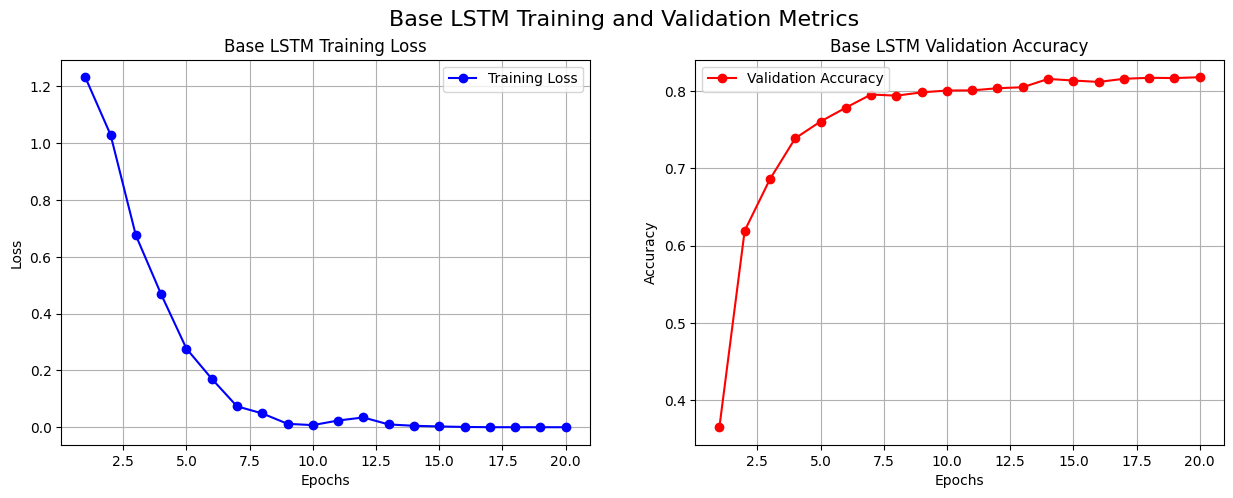

In [171]:
plot_history(lstm_train_losses, lstm_val_accuracies, title_prefix="Base LSTM")

## 5. 模型推理

In [172]:
# 加载资源
vocab_path = os.path.join(hparams["output_dir"], 'vocab.json')
with open(vocab_path, 'r', encoding='utf-8') as f:
    loaded_vocab = json.load(f)

labels_path = os.path.join(hparams["output_dir"], 'label_map.json')
with open(labels_path, 'r', encoding='utf-8') as f:
    label_map_loaded = json.load(f)

# 实例化推理组件
inference_tokenizer = Tokenizer(vocab=loaded_vocab)
inference_model = TextClassifierLSTM(
    vocab_size=len(inference_tokenizer),
    embed_dim=hparams["embed_dim"], 
    hidden_dim=hparams["hidden_dim"], 
    num_classes=len(label_map_loaded),
    n_layers=hparams["n_layers"],
    dropout=hparams["dropout"],
    bidirectional=hparams["bidirectional"]
).to(hparams["device"])

model_path = os.path.join(hparams["output_dir"], "best_model.pth")
inference_model.load_state_dict(torch.load(model_path, map_location=hparams["device"]))

<All keys matched successfully>

In [173]:
predictor = Predictor(
    inference_model, 
    inference_tokenizer, 
    label_map_loaded, 
    hparams["device"]
)

# 预测
new_text = "The doctor prescribed a new medicine for the patient's illness, focusing on its gpu accelerated healing properties."
predicted_class = predictor.predict(new_text)

{"text": new_text, "pred": predicted_class}

{'text': "The doctor prescribed a new medicine for the patient's illness, focusing on its gpu accelerated healing properties.",
 'pred': 'sci.med'}

## 6. 过拟合解决方案

In [174]:
import random

class TextClassificationDatasetWithMasking(TextClassificationDataset):
    """
    继承自TextClassificationDataset，并增加了在训练时随机遮盖Token的功能。
    """
    def __init__(self, texts, labels, tokenizer, max_len=128, is_train=False, mask_prob=0.1):
        """
        新增参数:
        is_train (bool): 是否为训练集。只对训练集进行遮盖。
        mask_prob (float): 单个Token被遮盖的概率。
        """
        super().__init__(texts, labels, tokenizer, max_len)
        self.is_train = is_train
        self.mask_prob = mask_prob
        # 获取<UNK>的ID，用于替换
        self.unk_token_id = tokenizer.token_to_id.get("<UNK>", 1)

    def __getitem__(self, idx):
        # 首先调用父类的方法获取原始数据，并创建副本
        item = super().__getitem__(idx).copy()
        
        # 如果是训练集，则执行随机遮盖
        if self.is_train:
            token_ids = item['token_ids']
            masked_token_ids = []
            for token_id in token_ids:
                # PAD token (ID=0) 不应被遮盖
                if token_id != 0 and random.random() < self.mask_prob:
                    masked_token_ids.append(self.unk_token_id)
                else:
                    masked_token_ids.append(token_id)
            # 用遮盖后的序列替换原始序列
            item['token_ids'] = masked_token_ids
            
        return item

In [175]:
class TrainerWithEarlyStopping(Trainer):
    """
    继承自Trainer，并增加了提前停止的功能。
    """
    def __init__(self, model, optimizer, criterion, train_loader, valid_loader, device, output_dir=".", patience=3):
        """
        新增参数:
        patience (int): 连续patience个epoch验证集表现没有提升后，停止训练。
        """
        super().__init__(model, optimizer, criterion, train_loader, valid_loader, device, output_dir)
        self.patience = patience
        self.epochs_no_improve = 0

    def train(self, epochs, tokenizer, label_map):
        self.train_losses = []
        self.val_accuracies = []
        for epoch in range(epochs):
            avg_loss = self._run_epoch(epoch)
            val_accuracy = self._evaluate(epoch)
            
            self.train_losses.append(avg_loss)
            self.val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}/{epochs} | 训练损失: {avg_loss:.4f} | 验证集准确率: {val_accuracy:.4f}")
            
            # 记录调用_save_checkpoint之前的最佳准确率
            current_best = self.best_accuracy
            self._save_checkpoint(epoch, val_accuracy)
            
            # 检查最佳准确率是否有更新
            if self.best_accuracy > current_best:
                self.epochs_no_improve = 0
            else:
                self.epochs_no_improve += 1
            
            # 如果达到patience，则提前停止
            if self.epochs_no_improve >= self.patience:
                print(f"\n提前停止于 Epoch {epoch+1}，因为验证集准确率连续 {self.patience} 轮未提升。")
                break
        
        print("\n训练完成！")
        # 保存词典和标签映射
        vocab_path = os.path.join(self.output_dir, 'vocab.json')
        with open(vocab_path, 'w', encoding='utf-8') as f:
           json.dump(tokenizer.vocab, f, ensure_ascii=False, indent=4)
           
        labels_path = os.path.join(self.output_dir, 'label_map.json')
        with open(labels_path, 'w', encoding='utf-8') as f:
           json.dump(label_map, f, ensure_ascii=False, indent=4)
        print(f"词典 ({vocab_path}) 和标签映射 ({labels_path}) 已保存。")
        return self.train_losses, self.val_accuracies


In [176]:
# 1. 构建带有数据增强的Dataset和DataLoader
# 训练集使用新的Dataset，并开启is_train和mask_prob
train_dataset_reg = TextClassificationDatasetWithMasking(
    train_dataset_raw.data, 
    train_dataset_raw.target, 
    tokenizer,
    is_train=True,
    mask_prob=0.1
)
train_loader_reg = DataLoader(train_dataset_reg, batch_size=32, shuffle=True, collate_fn=collate_fn)

# 验证集保持不变，不进行数据增强
# 注意：valid_dataset是之前已经创建好的不带masking的dataset
valid_loader_reg = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn)

len(train_dataset_reg), len(valid_dataset)

100%|██████████| 2257/2257 [00:00<00:00, 4622.11it/s]


(7142, 5408)

In [177]:
# 2. 定义新的超参数
hparams_reg = hparams.copy()
hparams_reg["output_dir"] = "output_lstm_regularized"
hparams_reg

{'vocab_size': 10983,
 'embed_dim': 128,
 'hidden_dim': 256,
 'num_classes': 4,
 'n_layers': 2,
 'dropout': 0,
 'bidirectional': True,
 'epochs': 20,
 'learning_rate': 0.001,
 'device': 'cuda',
 'output_dir': 'output_lstm_regularized'}

In [178]:
# 3. 实例化模型、优化器
model_reg = TextClassifierLSTM(
    vocab_size=hparams_reg["vocab_size"], 
    embed_dim=hparams_reg["embed_dim"], 
    hidden_dim=hparams_reg["hidden_dim"], 
    num_classes=hparams_reg["num_classes"],
    n_layers=hparams_reg["n_layers"],
    dropout=0.3,
    bidirectional=hparams_reg["bidirectional"]
).to(hparams_reg["device"])

optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=hparams_reg["learning_rate"])

# 损失函数可以复用之前定义的 criterion
model_reg

TextClassifierLSTM(
  (embedding): Embedding(10983, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier): Linear(in_features=512, out_features=4, bias=True)
)

In [179]:
# 4. 实例化新的Trainer并开始训练
trainer_reg = TrainerWithEarlyStopping(
    model_reg, 
    optimizer_reg, 
    criterion, 
    train_loader_reg, 
    valid_loader_reg, 
    hparams_reg["device"], 
    output_dir=hparams_reg["output_dir"],
    patience=3
)

reg_lstm_train_losses, reg_lstm_val_accuracies = trainer_reg.train(epochs=hparams_reg["epochs"], tokenizer=tokenizer, label_map=label_map)

Epoch 1 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 85.75it/s]


Epoch 1/20 | 训练损失: 1.1924 | 验证集准确率: 0.5133
新最佳模型已保存! Epoch: 1, 验证集准确率: 0.5133


Epoch 2 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 84.93it/s]


Epoch 2/20 | 训练损失: 0.9189 | 验证集准确率: 0.6215
新最佳模型已保存! Epoch: 2, 验证集准确率: 0.6215


Epoch 3 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 87.19it/s]


Epoch 3/20 | 训练损失: 0.8116 | 验证集准确率: 0.6030


Epoch 4 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 86.64it/s]


Epoch 4/20 | 训练损失: 0.6231 | 验证集准确率: 0.6518
新最佳模型已保存! Epoch: 4, 验证集准确率: 0.6518


Epoch 5 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 81.32it/s]


Epoch 5/20 | 训练损失: 0.3817 | 验证集准确率: 0.7332
新最佳模型已保存! Epoch: 5, 验证集准确率: 0.7332


Epoch 6 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 80.29it/s]


Epoch 6/20 | 训练损失: 0.2656 | 验证集准确率: 0.7663
新最佳模型已保存! Epoch: 6, 验证集准确率: 0.7663


Epoch 7 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 83.36it/s]


Epoch 7/20 | 训练损失: 0.1885 | 验证集准确率: 0.7953
新最佳模型已保存! Epoch: 7, 验证集准确率: 0.7953


Epoch 8 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 74.71it/s]


Epoch 8/20 | 训练损失: 0.1579 | 验证集准确率: 0.7999
新最佳模型已保存! Epoch: 8, 验证集准确率: 0.7999


Epoch 9 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 79.26it/s]


Epoch 9/20 | 训练损失: 0.0788 | 验证集准确率: 0.8010
新最佳模型已保存! Epoch: 9, 验证集准确率: 0.8010


Epoch 10 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 80.02it/s]


Epoch 10/20 | 训练损失: 0.0676 | 验证集准确率: 0.8003


Epoch 11 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 70.50it/s]


Epoch 11/20 | 训练损失: 0.0645 | 验证集准确率: 0.8197
新最佳模型已保存! Epoch: 11, 验证集准确率: 0.8197


Epoch 12 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 83.87it/s]


Epoch 12/20 | 训练损失: 0.0371 | 验证集准确率: 0.8129


Epoch 13 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 82.12it/s]


Epoch 13/20 | 训练损失: 0.0351 | 验证集准确率: 0.8221
新最佳模型已保存! Epoch: 13, 验证集准确率: 0.8221


Epoch 14 [评估中]: 100%|██████████| 169/169 [00:02<00:00, 79.36it/s]


Epoch 14/20 | 训练损失: 0.0211 | 验证集准确率: 0.8162


Epoch 15 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 97.18it/s] 


Epoch 15/20 | 训练损失: 0.0163 | 验证集准确率: 0.8192


Epoch 16 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 97.13it/s]


Epoch 16/20 | 训练损失: 0.0216 | 验证集准确率: 0.8369
新最佳模型已保存! Epoch: 16, 验证集准确率: 0.8369


Epoch 17 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 94.98it/s]


Epoch 17/20 | 训练损失: 0.0176 | 验证集准确率: 0.8243


Epoch 18 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 96.61it/s]


Epoch 18/20 | 训练损失: 0.0172 | 验证集准确率: 0.8175


Epoch 19 [评估中]: 100%|██████████| 169/169 [00:01<00:00, 95.57it/s]

Epoch 19/20 | 训练损失: 0.0136 | 验证集准确率: 0.8066

提前停止于 Epoch 19，因为验证集准确率连续 3 轮未提升。

训练完成！
词典 (output_lstm_regularized\vocab.json) 和标签映射 (output_lstm_regularized\label_map.json) 已保存。


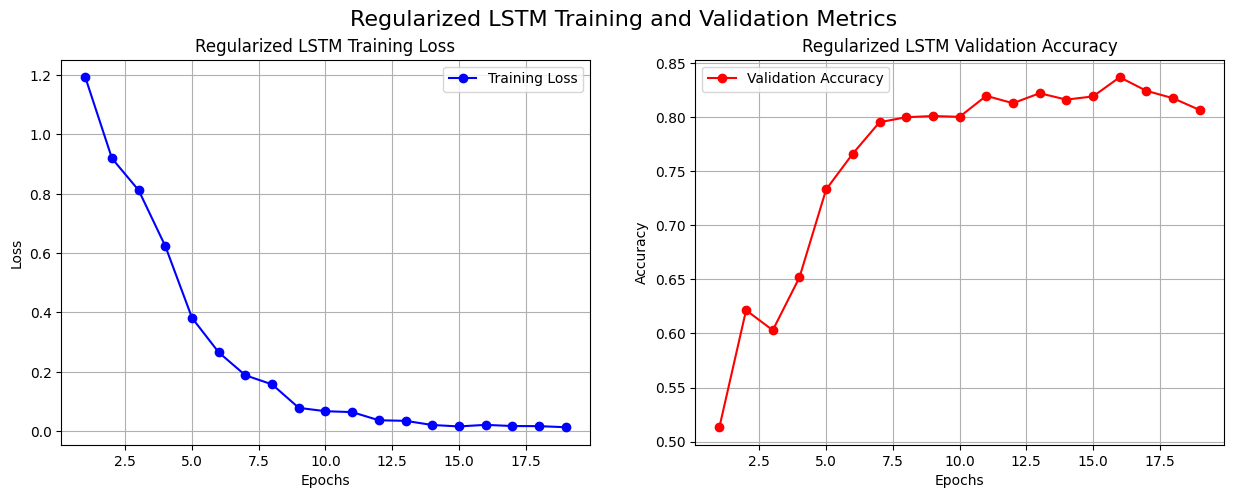

In [180]:
plot_history(reg_lstm_train_losses, reg_lstm_val_accuracies, title_prefix="Regularized LSTM")